# Testing

In [10]:
from plotting_utils import *

def plot(ax, data, field, plot_term, params, smooth = None):
    '''data is already in filtered form
    data: {name:list of data_points} '''
    def last(a):
        return a[-1]

    all_plots = []
    lookup = set()
    exclude_last_points = 1
    for k, v in data.items():
        if plot_term in k:
            exp_id = k.split("_")
            ind = exp_id.index(plot_term)
            plot_term_value = exp_id[ind+1]
            if not plot_term_value in lookup:
                lookup.add(plot_term_value)
                label = params["aliasplotterm"] + ' = ' + plot_term_value
                if not smooth is None:
                    new_data = moving_average_filter(v[field], smooth)
                    exclude_last_points = smooth + 1
                else:
                    new_data = v[field][:]
                x = np.arange(len(new_data))
                ax.plot(x[5:-exclude_last_points], new_data[5:-exclude_last_points], label = label)
                #all_plots.append((handle,label, float(plot_term_value)))
    
    handles, labels = ax.get_legend_handles_labels()
    label_id = [float(l.split(" = ")[-1]) for l in labels]
    all_plots = [tuple(i) for i in zip(handles, labels, label_id)]
    all_plots.sort(key = last, reverse=True)


   # print(handles, labels)
    ax.set_xlabel(params["xlabel"])  # Add an x-label to the axes.
    ax.set_ylabel(params["ylabel"])  # Add a y-label to the axes.
    ax.set_title(params["title"])  # Add a title to the axes.
  #  handles = [p[0] for p in all_plots]
  #  lbls = [p[1] for p in all_plots]
    h,l,_ = zip(*all_plots)
    ax.legend(h, l)  # Add a legend.


In [8]:
#from matplotlib import style
#style.use('ggplot')


import matplotlib.pyplot as plt

# Set the style globally
# Alternatives include bmh, fivethirtyeight, ggplot,
# dark_background, seaborn-deep, etc
plt.style.use('ggplot')



# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Ubuntu'
# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['figure.titleweight'] = 'bold'

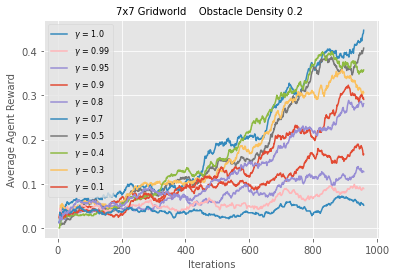

In [9]:
file = '/home/james/Desktop/Gridworld/test/test2'

fig, ax = plt.subplots()

all_data = get_event_data(file)

filter_terms = ["envsize_7"]
field = "agent_dones"
plot_term = "disc"
params = {"title": "7x7 Gridworld    Obstacle Density 0.2 ",
         "xlabel": "Iterations",
         "ylabel": "Average Agent Reward",
         "aliasplotterm": "$\gamma$"}

data = filter(all_data, filter_terms)
plot(ax, data, field, plot_term, params, smooth=40)

#ax.set_xlabel('x label')  # Add an x-label to the axes.
#ax.set_ylabel('y label')  # Add a y-label to the axes.
#ax.set_title("Simple Plot")  # Add a title to the axes.
#ax.legend()  # Add a legend.
plt.show()

In [3]:
#make_path("test/test2.png")
#fig.savefig(make_exist("test3/test.png"))

# Hello world $\gamma$